In [32]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

input_img = imread('images/sample.jpg')[:,:,0]

import pyclesperanto_prototype as cle

cle.select_device('Quadro')

/home/rdave/Spring24/mit-hackathon/mit-hack/lib/python3.10/site-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with Quadro in their name. Using pthread-Intel(R) Core(TM) i7-10850H CPU @ 2.70GHz instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<pthread-Intel(R) Core(TM) i7-10850H CPU @ 2.70GHz on Platform: Portable Computing Language (48 refs)>

cl.OCLArray([[253., 253., 255., ..., 255., 255., 253.],
       [255., 253., 255., ..., 255., 253., 255.],
       [253., 255., 253., ..., 255., 255., 253.],
       ...,
       [255., 255., 255., ..., 255., 253., 253.],
       [253., 255., 253., ..., 253., 255., 255.],
       [253., 253., 255., ..., 253., 253., 253.]], dtype=float32)
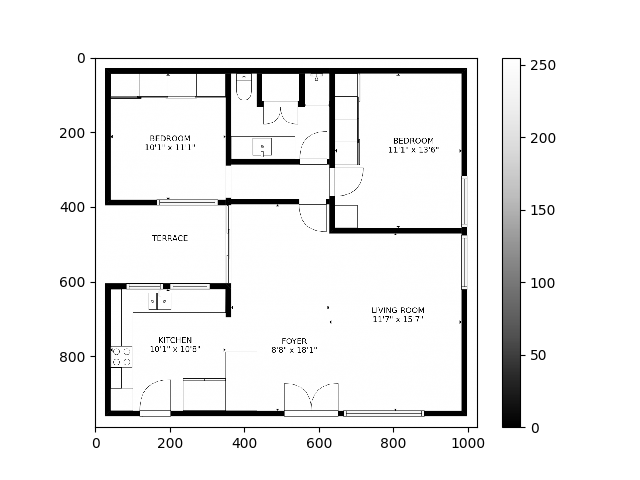
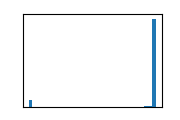

In [7]:
input_gpu = cle.push(input_img)
input_gpu

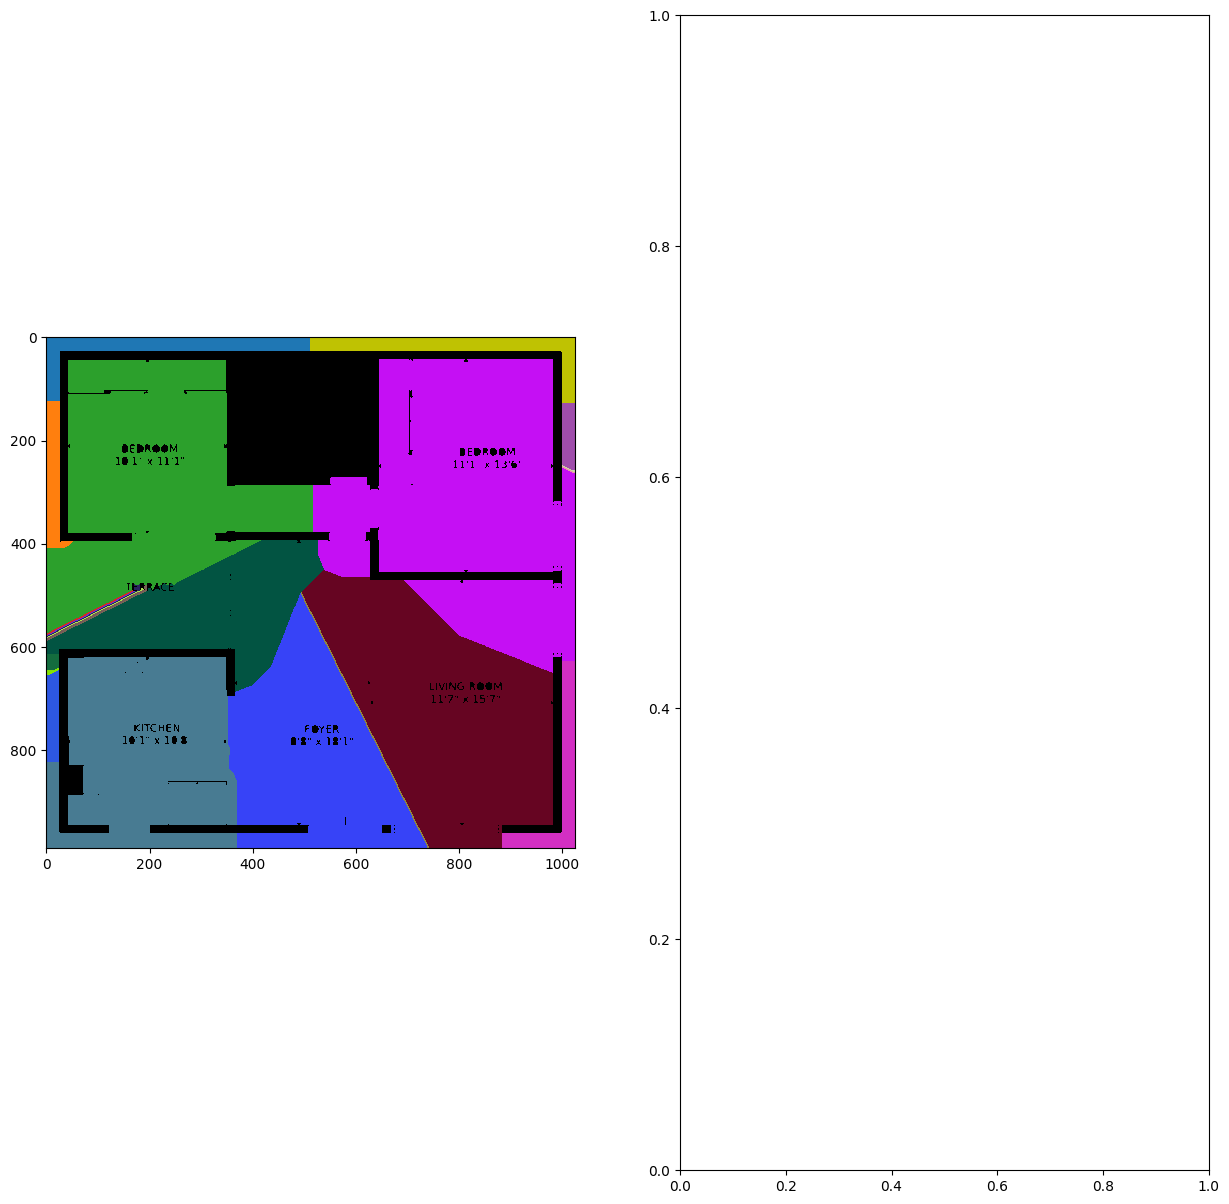

In [19]:
sigma_spot_detection = 220
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(segmented, labels=True, plot=axs[0])


In [37]:
preimg = input_img

from skimage import util
image_to_segment = util.invert(preimg)
print(image_to_segment.shape)

(1342, 2000)


number of detected spots 23.0
number of selected spots 15.0


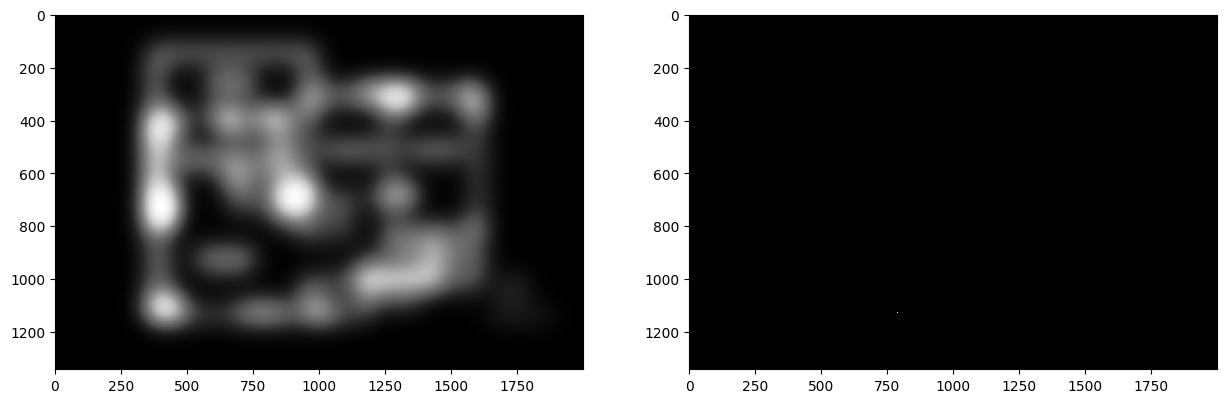

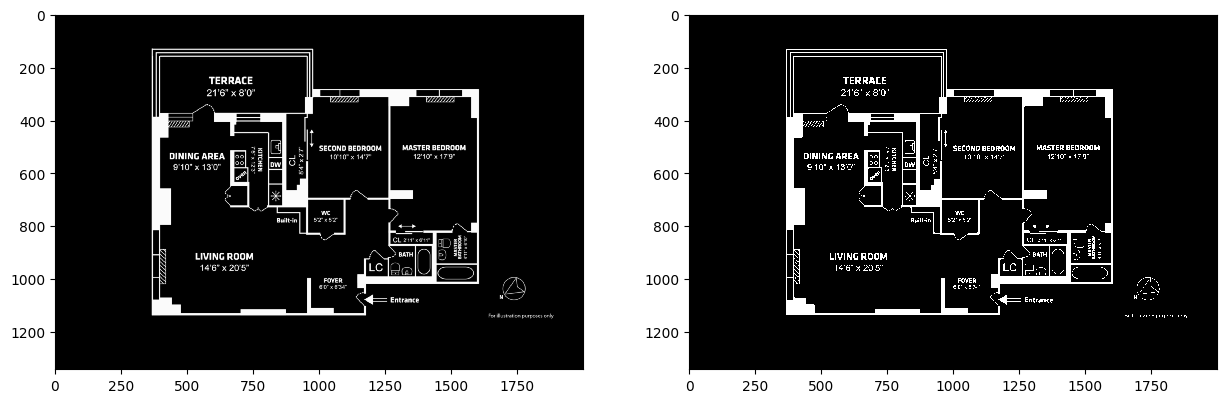

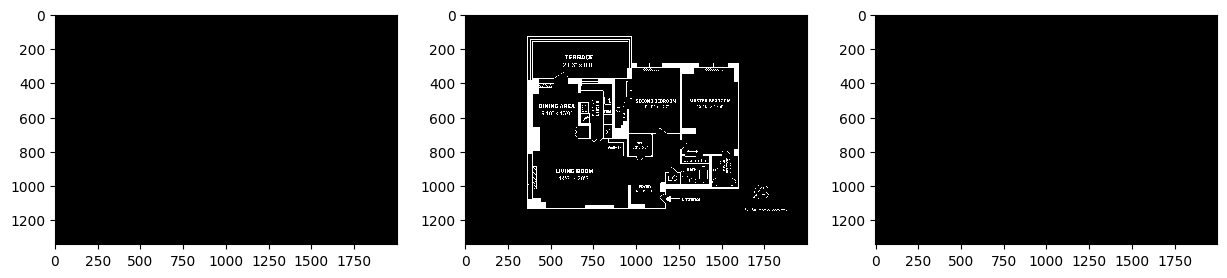

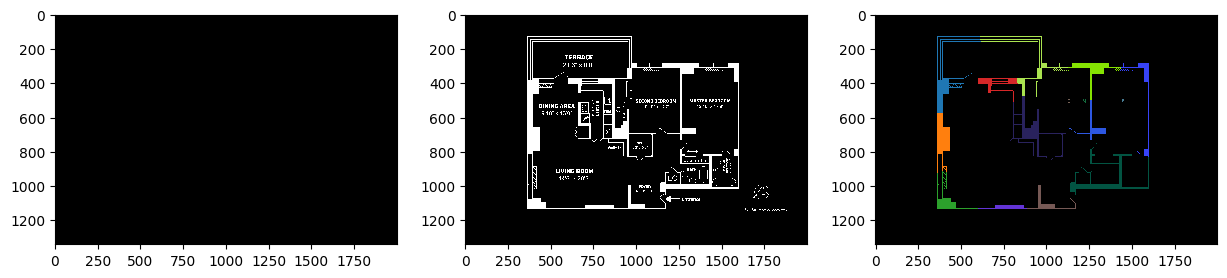

In [38]:
# sigma_spot_detection = 220
sigma_spot_detection = 50
sigma_outline = 1

blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)
detected_spots = cle.detect_maxima_box(blurred, radius_x=0, radius_y=0, radius_z=0)
number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("number of detected spots", number_of_spots)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(blurred, plot=axs[0])
cle.imshow(detected_spots, plot=axs[1])

blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
binary = cle.threshold_otsu(blurred)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(blurred, plot=axs[0])
cle.imshow(binary, plot=axs[1])

selected_spots = cle.binary_and(binary, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("number of selected spots", number_of_spots)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(detected_spots, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(selected_spots, plot=axs[2])

voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(selected_spots, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(voronoi_diagram, labels=True, plot=axs[2])

In [44]:
import cv2 as cv
img = cv.imread('images/floor1.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [46]:
import numpy as np
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

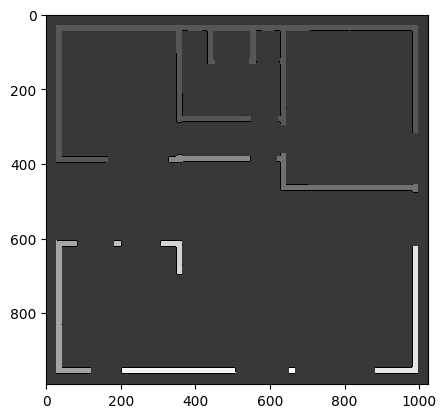

In [55]:
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]
cle.imshow(markers)